for colab

In [1]:
!git clone https://github.com/smks17/todels

fatal: destination path 'todels' already exists and is not an empty directory.


In [2]:
%cd todels

/content/todels


# Imports

In [3]:
from random import random, sample
from time import time
from copy import deepcopy

from todels.autoencoder import VAE
from todels.utils import ProgressBar

import torch
import torch.nn as nn
from torchvision import transforms, datasets

import numpy as np
import matplotlib.pyplot as plt

In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
if device == torch.device("cuda:0"):
    print(device, torch.cuda.get_device_name(0))
else:
    print("CPU")

cuda:0 Tesla T4


In [5]:
print("Pytorch version:", torch.__version__)

Pytorch version: 2.0.1+cu118


# Parameters

In [6]:
valid_data_size = 0.1
batch_size = 64
epochs = 30
lr = 0.001
weight_decay = 1e-5

# Load Dataset

In [7]:
train_data = datasets.CIFAR10(root='./data', train=True, download=True, transform=transforms.ToTensor())
test_data = datasets.CIFAR10(root='./data', train=False, download=True, transform=transforms.ToTensor())

Files already downloaded and verified
Files already downloaded and verified


In [8]:
indices = list(range(len(train_data)))
np.random.shuffle(indices)
split = int(np.floor((1 - valid_data_size) * len(train_data)))
train_sample = torch.utils.data.SubsetRandomSampler(indices[:split])
valid_sample = torch.utils.data.SubsetRandomSampler(indices[split:])

trainloader = torch.utils.data.DataLoader(train_data, sampler=train_sample, batch_size=batch_size, num_workers=2)
validloader = torch.utils.data.DataLoader(train_data, sampler=valid_sample, batch_size=batch_size, num_workers=2)
testloader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=False, num_workers=2)

In [9]:
classes = (
    'plane',
    'car',
    'bird',
    'cat',
    'deer',
    'dog',
    'frog',
    'horse',
    'ship',
    'truck'
)

# Show Samples

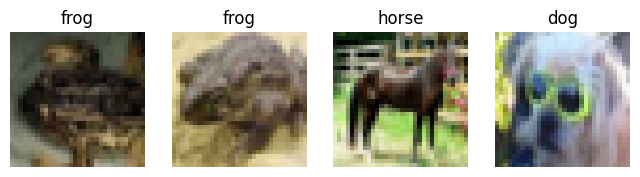

In [10]:
fig, ax = plt.subplots(1, 4, figsize=(8, 8))
for i in range(4):
    sample_idx = torch.randint(len(train_data), size=(1,)).item()
    ax[i].set_title(classes[train_data[sample_idx][1]])
    ax[i].imshow(train_data[sample_idx][0].swapaxes(0,1).swapaxes(1,2))
    ax[i].axis(False)
plt.show()

# Functions

## Test Function

In [11]:
def test(model, test_loader, loss_function=None, return_confusion=False):
    accuracy = 0
    total = 0
    running_loss = 0
    if return_confusion:
        confusion_matrix = np.zeros((len(classes), len(classes)), dtype=np.int32)
    with torch.no_grad():
        for (images, _) in test_loader:
            images = images.to(device, non_blocking=True)
            # predict
            out, mu, var = model(images)
            total += images.size(0)
            if loss_function is not None:
                recostruct_loss = loss_function(out, images)
                loss = model.cal_loss(out, recostruct_loss, mu, var, kld_weight=0.01)
                running_loss += loss.item()
    res = [(accuracy / total * 100.)]
    if loss_function is not None:
        res += [(running_loss/len(test_loader))]
    return res

## Train function

In [12]:
def train(model, train_loader, validation_loader, optim, loss_function, epochs):
    losses = []
    val_losses = []
    accuracies = []
    val_accuracies = []
    best_accuracy = 0
    total_time_train = 0

    for i in range(epochs):
        pbar = ProgressBar(i+1, n_samples=len(train_loader), length_bar=40)
        running_loss = 0
        model.zero_grad()
        accuracy = 0
        total_size = 0
        for batch, (images, _) in enumerate(train_loader):
            # move to target device (gpu)
            images = images.to(device, non_blocking=True)
            # predict
            out, mu, var = model(images)
            # cal loss
            recostruct_loss = loss_function(out, images)
            loss = model.cal_loss(out, recostruct_loss, mu, var, kld_weight=0.01)
            loss.backward()
            running_loss += loss.data
            # optimazer step
            optim.step()
            model.zero_grad()
            # update progress bar
            pbar.next(batch=batch, addition_output=f"loss={running_loss/(batch+1):>.4f}")

        total_time_train += pbar.take_time
        # append to history
        losses.append((running_loss / len(train_loader)).item())

        # test validation data
        val_accuracy, val_loss = test(model, validation_loader, loss_function)
        val_losses.append(val_loss)

        # step progress_bar
        addition_output = f"loss = {losses[-1]:>.4f} - val_loss = {val_losses[-1]:>.4f}"
        pbar.next(batch=len(train_loader), addition_output=addition_output)

    print(f"----------\n total time for train: {total_time_train / 60.}min")
    return {"loss": losses, "val_loss": val_losses}

## Show Sample Predict

In [13]:
def show_predicts(model, test_data, n_test=5):
    fig, ax = plt.subplots(2, n_test, figsize=(20, 6))
    model.eval()  # Sets the module in evaluation mode not train mode
    with torch.no_grad():
        for i in range(n_test):
            rand_index = int(random() * (len(test_data) - 1))
            image = test_data[rand_index][0]

            ax[0, i].set_title(f"image")
            ax[0, i].imshow(image.swapaxes(0,1).swapaxes(1,2))
            ax[0, i].axis(False)

            image = image.to(device, non_blocking=True)
            image = image.unsqueeze(0)
            out, mu, var = model(image)

            ax[1, i].set_title(f"predict image")
            ax[1, i].imshow(out.squeeze().swapaxes(0,1).swapaxes(1,2).cpu().numpy())
            ax[1, i].axis(False)

            fig.tight_layout()
    plt.show()

# Model

## Encoder

In [14]:
class Encoder(nn.Module):
    def __init__(self, latent_size = 4096):
        super(Encoder, self).__init__()
        self.network = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=12, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(12),
            nn.ReLU(True),
            nn.Conv2d(in_channels=12, out_channels=24, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(24),
            nn.ReLU(True),
            nn.Conv2d(in_channels=24, out_channels=48, kernel_size=3, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(48),
            nn.ReLU(True),

            nn.Sequential(
                nn.Flatten(),
                nn.LazyLinear(latent_size),
            )
        )

    def forward(self, inputs):
        return self.network(inputs)

## Decoder

In [15]:
class Decoder(nn.Module):
    def __init__(self, latent_size=4096):
        super(Decoder, self).__init__()
        self.pre_decoder = nn.Sequential(
                nn.Linear(latent_size, 4*4*48),
        )

        self.network = nn.Sequential(
            nn.ConvTranspose2d(in_channels=48, out_channels=24, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(24),
            nn.ReLU(True),
            nn.ConvTranspose2d(in_channels=24, out_channels=12, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(12),
            nn.ReLU(True),
            nn.ConvTranspose2d(in_channels=12, out_channels=3, kernel_size=4, stride=2, padding=1, bias=True),
            nn.Sigmoid(),
        )

    def forward(self, inputs):
        out = self.pre_decoder(inputs)
        out = out.reshape(-1,48,4,4)
        out = self.network(out)
        return out

# Create Model & Train

In [16]:
model = VAE(Encoder(1024), Decoder(1024), 1024).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr ,weight_decay=weight_decay)

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


In [17]:
history = train(model, trainloader, validloader, optimizer, nn.functional.mse_loss, epochs)

 epochs 1: [=======================================>] 100%  time:19.754s - loss = 0.0294 - val_loss = 0.0195
 epochs 2: [=======================================>] 100%  time:12.363s - loss = 0.0141 - val_loss = 0.0134
 epochs 3: [=======================================>] 100%  time:12.816s - loss = 0.0111 - val_loss = 0.0115
 epochs 4: [=======================================>] 100%  time:13.840s - loss = 0.0098 - val_loss = 0.0120
 epochs 5: [=======================================>] 100%  time:11.953s - loss = 0.0090 - val_loss = 0.0098
 epochs 6: [=======================================>] 100%  time:12.082s - loss = 0.0085 - val_loss = 0.0093
 epochs 7: [=======================================>] 100%  time:12.363s - loss = 0.0082 - val_loss = 0.0101
 epochs 8: [=======================================>] 100%  time:11.879s - loss = 0.0079 - val_loss = 0.0084
 epochs 9: [=======================================>] 100%  time:12.689s - loss = 0.0076 - val_loss = 0.0082
 epochs 10: [======

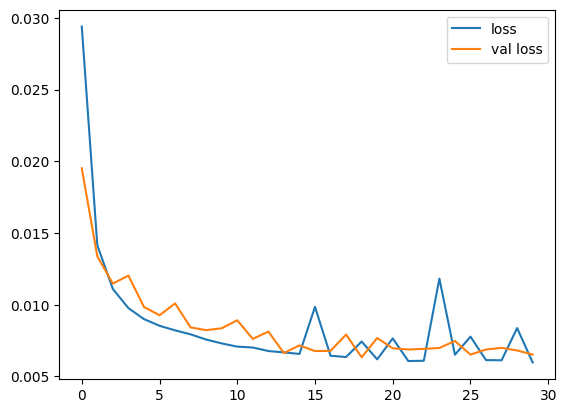

In [20]:
plt.plot(history["loss"], label="loss")
plt.plot(history["val_loss"], label="val loss")
plt.legend()
plt.show()

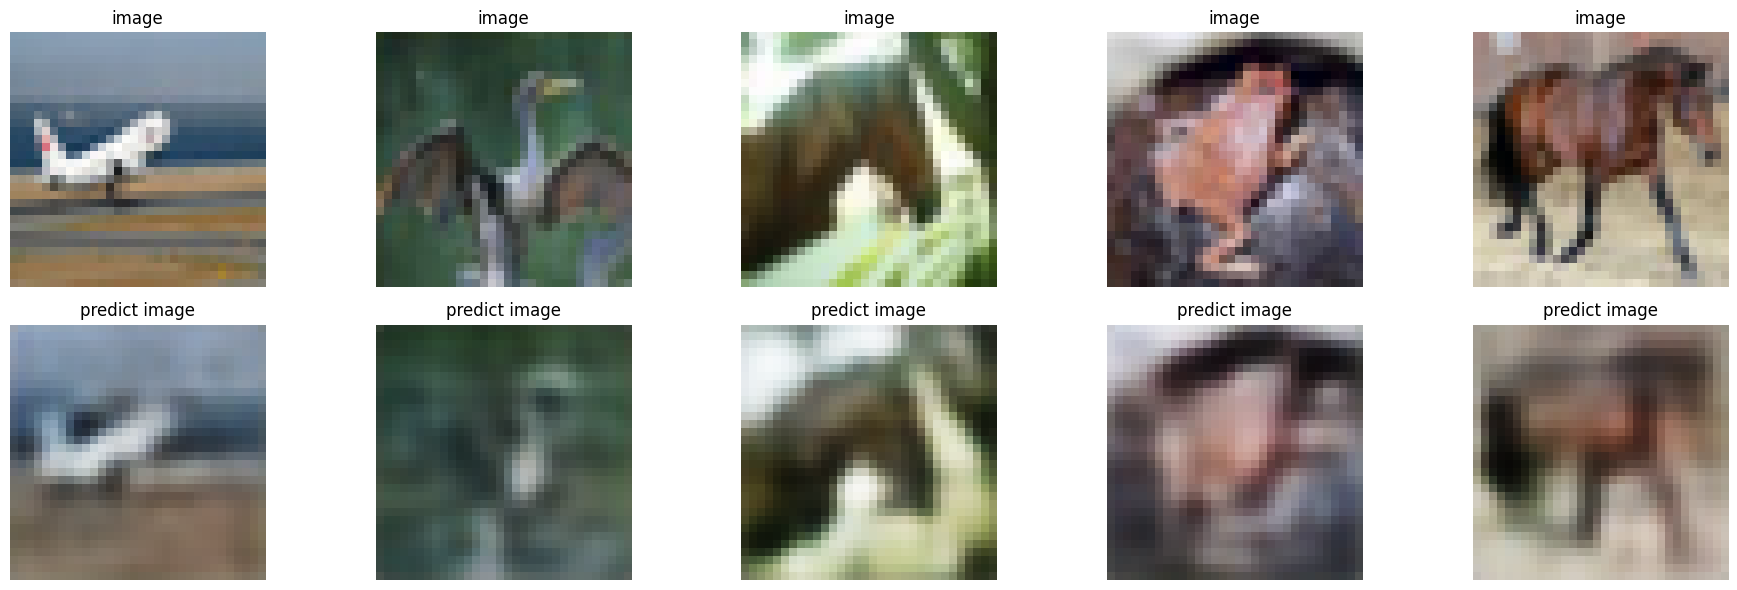

In [19]:
show_predicts(model, test_data)